### Notebook for Explainable AI for Transformer Architectures

This notebook contains code to get you started on applying explainable AI techniques on your Transformer Model. The code is based on the work described in the paper "XAI for Transformers: Better Explanations through Conservative Propagation" by Ali et al. (2022), to be found here: https://proceedings.mlr.press/v162/ali22a/ali22a.pdf and this is the link to the official repository on Github: https://github.com/AmeenAli/XAI_Transformers

### Imports & loading data

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np

from transformers import pipeline
import seaborn as sns


❗NB: This code works for models based on the BERT architecture. If you used a different transformer architecture (DistilBERT, RoBERTa, etc.), you might need to adapt some of the code to fit the architecutre requirements. 

In [11]:
# Load model and tokenizer
# This is a pre-trained BERT model taken from HuggingFace
#TODO: Insert your own model here! 

tokenizer = AutoTokenizer.from_pretrained("../../pipeline/translation_model")
model = AutoModelForSequenceClassification.from_pretrained("../../pipeline/pretrained_bert_model_w_metrics")



## Gradient x Input

The gradient_x_input function calculates token relevance using the Gradient × Input method. It converts input IDs to embeddings and enables gradient tracking. The embeddings are passed through the model, generating logits for prediction. The function computes gradients with respect to the predicted class, indicating how sensitive the prediction is to each token. If no gradients are computed, it raises an error to signal that the embeddings are not properly linked to the output. The gradients are multiplied by the input embeddings to calculate relevance scores, showing how much each token influenced the model’s prediction.

In [12]:
def gradient_x_input(model, inputs):
    inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
    inputs_embeds = inputs_embeds.clone().detach().requires_grad_(True)
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=inputs.attention_mask)
    outputs.logits[:, outputs.logits.argmax()].backward()
    # Fix for NoneType issue — return zero tensor if grad is None
    if inputs_embeds.grad is None:
        raise RuntimeError("Gradients are not computed! Make sure inputs_embeds is correctly passed through the model.")

    return inputs_embeds.grad * inputs_embeds




## Conservative Propagation

The ``modified_attention_forward`` function adjusts attention propagation by calculating attention scores using scaled dot product attention. It computes attention probabilities through softmax, then multiplies them with hidden states to get the context layer. Relevance scores are propagated back through the attention weights, to ensure a conservative flow of information. The ``modified_layernorm_forward`` function normalizes hidden states using the mean and variance, then redistributes relevance based on the normalization values. This follows the paper’s conservative propagation strategy, which stabilizes relevance flow through transformers by correcting how relevance is handled in attention and layer normalization layers.

In [13]:
# Attention Layer - Conservative Propagation
def modified_attention_forward(attention_layer, hidden_states, relevance_scores):
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1)**0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()
    context_layer = attention_probs @ hidden_states
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)
    return context_layer, propagated_relevance

# LayerNorm Layer - Conservative Propagation
def modified_layernorm_forward(layernorm_layer, hidden_states, relevance_scores):
    mean = hidden_states.mean(-1, keepdim=True)
    variance = hidden_states.var(-1, keepdim=True, unbiased=False)
    normed = (hidden_states - mean) / (variance + layernorm_layer.eps).sqrt()
    propagated_relevance = relevance_scores / (variance + layernorm_layer.eps).sqrt()
    return normed.detach(), propagated_relevance

### Pertubating

Perturbating means deliberately modifying or disturbing the input data to observe how the model's prediction changes. It helps identify which parts of the input are most influential by measuring the model's sensitivity to these changes. The ``perturb_input_and_evaluate`` function measures how sensitive the model’s prediction is to specific tokens by progressively modifying the input. It first tokenizes the input text and sorts tokens based on their relevance scores. If perturb_type is 'remove', the **least** relevant tokens are removed first; otherwise, the **most relevant** tokens are removed first. Tokens are replaced with [PAD] to maintain input length consistency. The modified texts are converted back into input tensors and passed through the model. The model’s confidence in its prediction is recorded after each perturbation using softmax probabilities. This allows evaluation of how much each token contributes to the final prediction by observing how the model’s confidence changes as tokens are progressively masked.

In [14]:
#TODO: Play around to see what happens if you remove the least or most relevant tokens first!

def perturb_input_and_evaluate(model, tokenizer, text, relevance_scores, perturb_type='remove'):
    tokens = tokenizer.tokenize(text)
    
    if perturb_type == 'remove':
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=False)
    else:
        sorted_indices = torch.argsort(relevance_scores[0].norm(dim=-1), descending=True)

    sorted_indices = sorted_indices.tolist()

    perturbed_texts = []
    for i in range(1, len(tokens) + 1):
        perturbed_tokens = tokens[:]
        for idx in sorted_indices[:i]:
            if idx < len(perturbed_tokens):
                perturbed_tokens[idx] = '[PAD]'
        perturbed_texts.append(tokenizer.convert_tokens_to_string(perturbed_tokens))

    confidences = []
    for pert_text in perturbed_texts:
        pert_inputs = tokenizer(pert_text, return_tensors='pt')
        pert_output = model(**pert_inputs)
        confidences.append(pert_output.logits.softmax(dim=-1).max().item())

    return confidences

## Visualisation of analysis

In [15]:
# Sample sentence for testing
# TODO: change this code block to run visualisations on your sentences!
# TODO: These are interesting visuals for your presentation. Why did you choose these sentences? Did you expect these outcomes? What does this tell you? 

# Your custom label mapping
pattern = {
    'happiness': 0,
    'anger': 1,
    'sadness': 2,
    'fear': 3,
    'disgust': 4,
    'surprise': 5,
    'neutral': 6
}

# Invert it for easy lookup by index
id2emotion = {v: k for k, v in pattern.items()}

# Sample sentence
text = "His unfair treatment made my blood boil with rage."
inputs = tokenizer(text, return_tensors='pt')

# Model prediction
outputs = model(**inputs)
logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()

# Use your custom mapping
predicted_emotion = id2emotion.get(predicted_class, "Unknown")
print(f"Predicted Emotion: {predicted_emotion}")


Predicted Emotion: neutral


#### Improved Gradient × Input with Conservative LRP

This code visualizes how much each token contributes to the model’s prediction using the Improved Gradient × Input with Conservative Layer-wise Relevance Propagation. LRP stands for Layer-wise Relevance Propagation. First, the ``gradient_x_input`` function computes relevance scores by calculating the gradient of the predicted class with respect to the input embeddings. These relevance scores show how sensitive the model’s prediction is to each token. The tokens are extracted using the tokenizer and plotted on a bar graph, with the bar height representing the magnitude of the relevance score. Higher bars indicate greater influence on the prediction. 

LRP explains model decisions by tracing relevance scores backward through the network. Basic LRP struggles with transformers due to unstable relevance flow through attention and layer normalization. Conservative LRP improves this by carefully redistributing relevance using attention weights and normalization values, making the explanations more stable, consistent, and accurately reflective of model behavior.

This explanation is labeled as "Improved LRP" because the conservative propagation technique from the paper improves the stability and consistency of relevance flow through the model.


**TODO: Can you explain what the colors represent?**

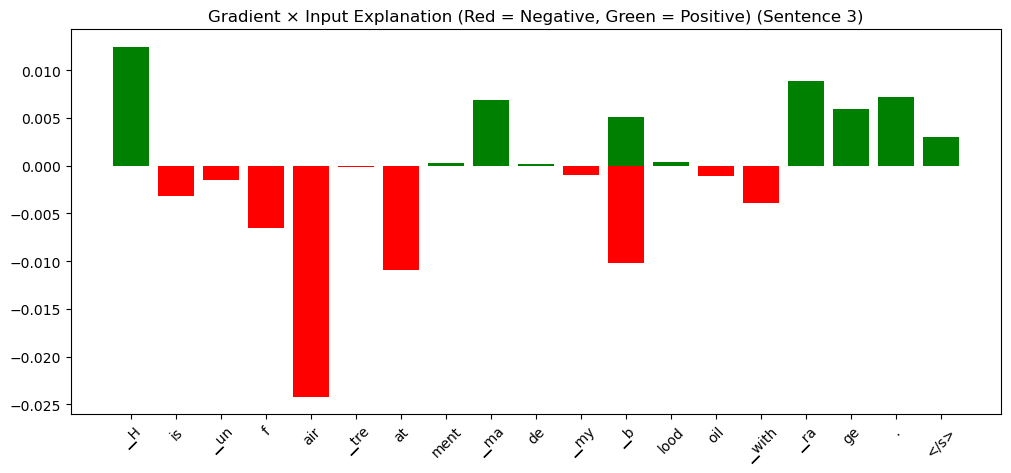

In [16]:
# Gradient x Input Explanation with Color-Coded Bars
relevance_scores = gradient_x_input(model, inputs)
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])


# Use raw relevance scores instead of L2 norm
raw_scores = relevance_scores[0].detach().numpy()

# Add color for positive/negative contribution based on raw values
colors = ['red' if score < 0 else 'green' for score in raw_scores[:, 0]]

plt.figure(figsize=(12, 5))
plt.bar(tokens, raw_scores[:, 0], color=colors)
plt.title("Gradient × Input Explanation (Red = Negative, Green = Positive) (Sentence 3)")
plt.xticks(rotation=45)
plt.show()

### Attention Scores

The attention scores heatmap visualizes how much each token in the input sequence influences other tokens during the model’s prediction. The rows represent the query tokens (the tokens seeking information), and the columns represent the key tokens (the tokens being attended to). The color intensity shows the strength of attention: dark red indicates strong attention, while dark blue indicates weak attention. A strong diagonal line suggests that the model is relying on self-attention, where each token is primarily focused on itself. High attention values between specific tokens indicate that the model considers them strongly related. Strong attention on a token suggests that the model recognizes its emotional importance. Scattered attention suggests the model is considering broader context, while concentrated attention on specific tokens shows that the model is focusing on particular details. The heatmap reflects how the model processes and builds relationships between tokens to understand context and meaning.

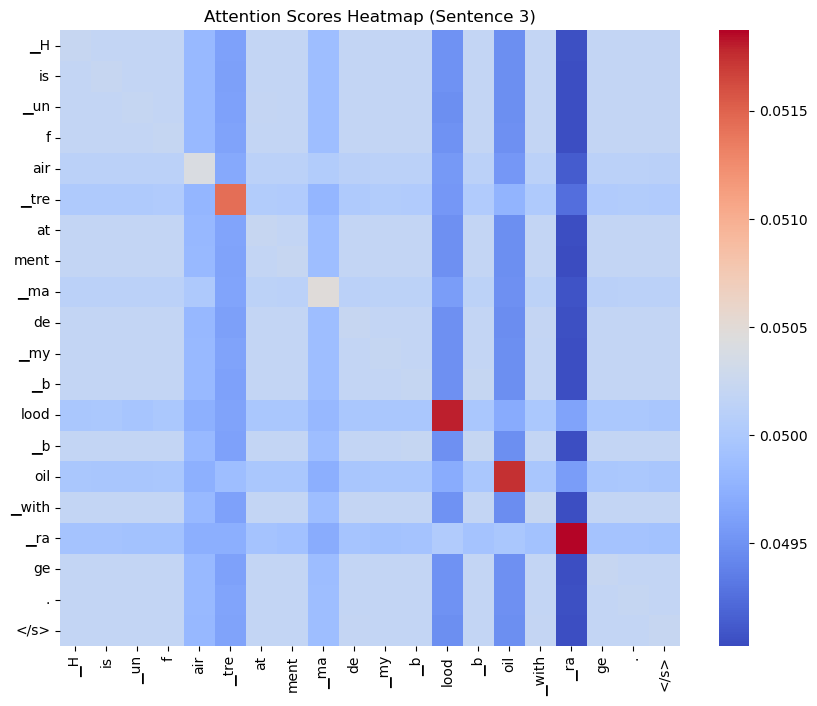

In [17]:
def visualize_attention_and_relevance(attention_probs, relevance_scores, tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_probs.detach().numpy(), cmap='coolwarm', xticklabels=tokens, yticklabels=tokens)
    plt.title('Attention Scores Heatmap (Sentence 3)')
    plt.show()

# Modify attention propagation function to add visualization:
def modified_attention_forward(attention_layer, hidden_states, relevance_scores):
    attention_scores = (hidden_states @ hidden_states.transpose(-1, -2)) / hidden_states.size(-1)**0.5
    attention_probs = attention_scores.softmax(dim=-1).detach()
    context_layer = attention_probs @ hidden_states
    propagated_relevance = (attention_probs.transpose(-1, -2) @ relevance_scores)

    # Visualise
    visualize_attention_and_relevance(attention_probs[0].detach(), propagated_relevance[0].detach(), tokens)

    return context_layer, propagated_relevance

# Get hidden states and relevance scores
inputs_embeds = model.get_input_embeddings()(inputs.input_ids)
hidden_states = inputs_embeds.clone().detach().requires_grad_(True)

# Start relevance from the predicted class activation
predicted_class = outputs.logits.argmax(dim=-1)
relevance_scores = torch.zeros_like(hidden_states)
relevance_scores[:, -1, :] = outputs.logits[:, predicted_class].unsqueeze(-1)

# Run modified attention with visualization
context_layer, propagated_relevance = modified_attention_forward(model.bert.encoder.layer[0].attention.self, hidden_states, relevance_scores)

### Model confidence during Token Removal

This code generates a plot that shows how the model’s confidence changes as tokens are progressively removed from the input. First, it ensures that the length of the token list and the confidence scores are aligned by setting min_length to the smaller of the two. Then, ``confidences_remove``, which contains the model’s confidence levels after each token removal, is converted to a NumPy array for compatibility with plotting functions.

The ``plt.plot()`` function creates a line plot where the x-axis represents the number of tokens removed and the y-axis shows the model’s confidence in its prediction. The plot shows how the model’s confidence changes after each token removal, helping to identify which tokens were most critical for the prediction.

A horizontal red line is drawn at a confidence level of 0.5 using ``plt.axhline()``, representing the threshold where the model’s confidence drops to a point where the prediction becomes uncertain. plt.fill_between() shades the area below 0.5 in red, visually highlighting where the model’s confidence drops below the threshold. This visualization helps reveal which tokens are most influential in maintaining the model’s confidence and where the prediction starts to break down as critical tokens are removed.

**TODO: Can you explain what this means? How is the removal applied? What does the 0.5 threshold represent and why is this important?**

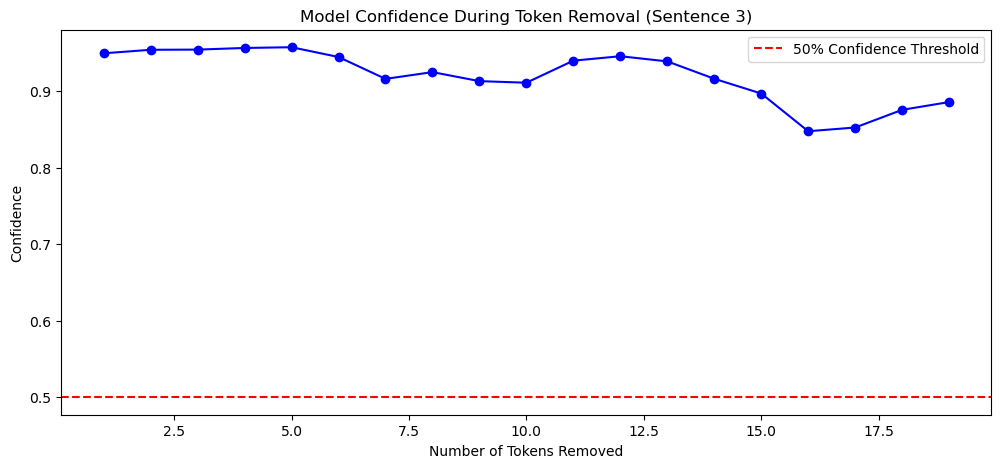

In [18]:
# Run function
confidences_remove = perturb_input_and_evaluate(model, tokenizer, text, relevance_scores, 'remove')

# Adjust length if mismatched
min_length = min(len(tokens), len(confidences_remove))

# Convert list to numpy array
confidences_remove = np.array(confidences_remove)

plt.figure(figsize=(12, 5))
plt.plot(range(1, min_length + 1), confidences_remove[:min_length], marker='o', color='blue')
plt.axhline(y=0.5, color='red', linestyle='--', label="50% Confidence Threshold")
plt.fill_between(
    range(1, min_length + 1), 
    confidences_remove[:min_length], 
    0.5, 
    where=(confidences_remove[:min_length] < 0.5), 
    color='red', 
    alpha=0.2
)
plt.title("Model Confidence During Token Removal (Sentence 3)")
plt.xlabel("Number of Tokens Removed")
plt.ylabel("Confidence")
plt.legend()
plt.show()